In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM games methods 
from models import *
from optim import *

import tensorflow as tf
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import copy as cp
from sklearn.model_selection import KFold

# MNIST digits:  2 environments

Below we illustrate how to use our IRM methods. 
We first setup the data in the cell below.  We set p_color_list = [0.2, 0.1] 
(from experiments in Arjovsky et.al.); note that there is marginal difference between the probabilities of 
switching the labels in the two environments. This marginal difference is useful for IRM methods to learn 
invariant predictors across environments that exploit the shape of digits and not the color. 

In [3]:
# Create data for each environment

n_env = 2  # number of environments

p_color_list = [0.2, 0.1] # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25] * n_env # list of probabilities of switching pre-label
D = assemble_data_mnist() # initialize mnist digits data object

D.create_training_data(n_env, p_color_list, p_label_list) # creates the training environments

p_label_test = 0.25 # probability of switching pre-label in test environment
p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_env)  # sets up the testing environment
(n_examples,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
n_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Select other hyper-parameters for the F-IRM game


In [4]:
n_epochs         = 1
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100
learning_rate    = 2.5e-4
beta_1           = 0.9
module_name      = "keras"
#module_name      = "pytorch"
optimizer_name   = "Adam"

### Create the models and the optimizers

In [5]:
models = create_models(module_name=module_name, 
                       n_env=n_env, 
                       length=length, 
                       width=width, 
                       height=height, 
                       n_classes=n_classes)

In [6]:
if module_name == "pytorch":
    params = [models[i_env].parameters() for i_env in range(n_env)]
else:
    params = None
    
optimizers = create_optimizers(module_name=module_name, 
                               optimizer_name=optimizer_name,
                               n_env=n_env, 
                               learning_rate=learning_rate,
                               beta_1=beta_1, 
                               params=params)

### Initialize F-IRM model, fit and evaluate

In [7]:
if module_name == "keras":
    game = TfFixedIrmGameModel
else:
    game = TorchFixedIrmGameModel

# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = game(models=models, 
              optimizers=optimizers, 
              n_epochs=n_epochs,
              batch_size=batch_size, 
              termination_acc=termination_acc, 
              warm_start=warm_start) 

# fit function runs the training on the data that we created
F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test)

Epoch 1/1...



Training accuracy: 0.8511
Testing accuracy: 0.0967


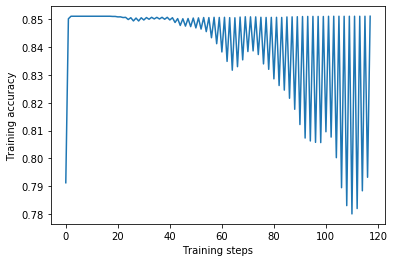

In [8]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accs)

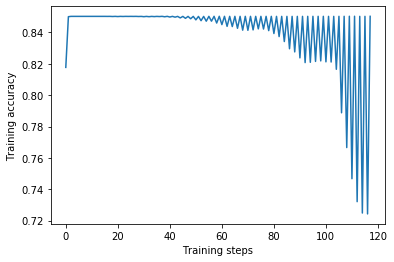

In [8]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accs)